In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import itertools

In [2]:
# fix random seeds for reproducibility (not perfect across TF versions)
np.random.seed(42)
tf.random.set_seed(42)


In [3]:
from tensorflow.keras.datasets import fashion_mnist
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [4]:
# Class names for display
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Quick sanity checks
print('Train samples:', x_train.shape[0])
print('Test samples: ', x_test.shape[0])
print('Image shape:   ', x_train.shape[1:])

Train samples: 60000
Test samples:  10000
Image shape:    (28, 28)


In [6]:
# Scale to [0,1]
x_train = x_train.astype('float32') / 255.0
x_test  = x_test.astype('float32')  / 255.0

In [5]:
# Flatten images for MLP (28x28 -> 784)
input_shape = (28 * 28,)
x_train_flat = x_train.reshape((-1, 28 * 28))
x_test_flat  = x_test.reshape((-1, 28 * 28))

In [7]:
model = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Dense(256, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(10, activation='softmax')
])

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │       200,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 235,146 (918.54 KB)

 Trainable params: 235,146 (918.54 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
# Optional callback: early stopping to avoid overfitting
es = callbacks.EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

history = model.fit(
    x_train_flat, y_train,
    validation_split=0.1,
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[es],
    verbose=2
)

Epoch 1/10
844/844 - 7s - 8ms/step - accuracy: 0.7317 - loss: 2.8341 - val_accuracy: 0.7797 - val_loss: 0.6754
Epoch 2/10
844/844 - 5s - 5ms/step - accuracy: 0.8008 - loss: 0.5685 - val_accuracy: 0.8230 - val_loss: 0.5837
Epoch 3/10
844/844 - 6s - 7ms/step - accuracy: 0.8316 - loss: 0.4768 - val_accuracy: 0.8225 - val_loss: 0.5320
Epoch 4/10
844/844 - 5s - 5ms/step - accuracy: 0.8433 - loss: 0.4370 - val_accuracy: 0.8342 - val_loss: 0.4928
Epoch 5/10
844/844 - 5s - 6ms/step - accuracy: 0.8523 - loss: 0.4144 - val_accuracy: 0.8433 - val_loss: 0.4563
Epoch 6/10
844/844 - 6s - 7ms/step - accuracy: 0.8569 - loss: 0.3975 - val_accuracy: 0.8417 - val_loss: 0.4645
Epoch 7/10
844/844 - 5s - 6ms/step - accuracy: 0.8639 - loss: 0.3759 - val_accuracy: 0.8495 - val_loss: 0.4415
Epoch 8/10
844/844 - 6s - 7ms/step - accuracy: 0.8676 - loss: 0.3702 - val_accuracy: 0.8505 - val_loss: 0.4469
Epoch 9/10
844/844 - 5s - 5ms/step - accuracy: 0.8710 - loss: 0.3586 - val_accuracy: 0.8585 - val_loss: 0.4320
E

In [9]:
# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
loss = tf.keras.losses.SparseCategoricalCrossentropy()
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
# Training setup
batch_size = 64
epochs = 10

In [10]:
# Evaluate on test set
test_loss, test_acc = model.evaluate(x_test_flat, y_test, verbose=0)
train_loss, train_acc = model.evaluate(x_train_flat, y_train, verbose=0)
print('\nFinal training accuracy: {:.4f}'.format(train_acc))
print('Final test accuracy:     {:.4f}'.format(test_acc))


Final training accuracy: 0.0410
Final test accuracy:     0.0410


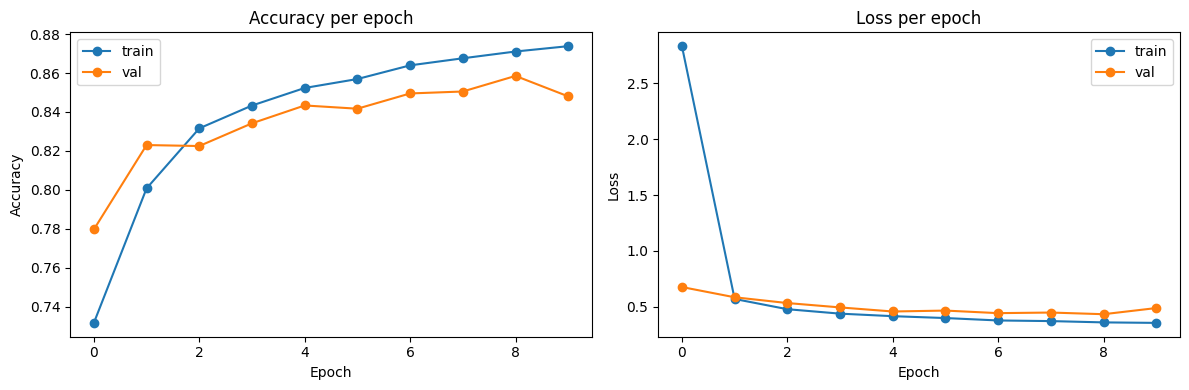

In [14]:
#  Plots: Loss and Accuracy per epoch

def plot_history(hist):
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))

    # accuracy
    axs[0].plot(hist.history['accuracy'], marker='o')
    axs[0].plot(hist.history['val_accuracy'], marker='o')
    axs[0].set_title('Accuracy per epoch')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Accuracy')
    axs[0].legend(['train', 'val'])

    # loss
    axs[1].plot(hist.history['loss'], marker='o')
    axs[1].plot(hist.history['val_loss'], marker='o')
    axs[1].set_title('Loss per epoch')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Loss')
    axs[1].legend(['train', 'val'])

    plt.tight_layout()
    plt.show()

plot_history(history)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Classification report:

              precision    recall  f1-score   support

 T-shirt/top     0.6590    0.8830    0.7547      1000
     Trouser     0.9758    0.9690    0.9724      1000
    Pullover     0.7178    0.7810    0.7481      1000
       Dress     0.7496    0.9310    0.8305      1000
        Coat     0.8029    0.6600    0.7245      1000
      Sandal     0.9617    0.9540    0.9578      1000
       Shirt     0.7887    0.4180    0.5464      1000
     Sneaker     0.9337    0.9570    0.9452      1000
         Bag     0.9727    0.9610    0.9668      1000
  Ankle boot     0.9653    0.9460    0.9556      1000

    accuracy                         0.8460     10000
   macro avg     0.8527    0.8460    0.8402     10000
weighted avg     0.8527    0.8460    0.8402     10000



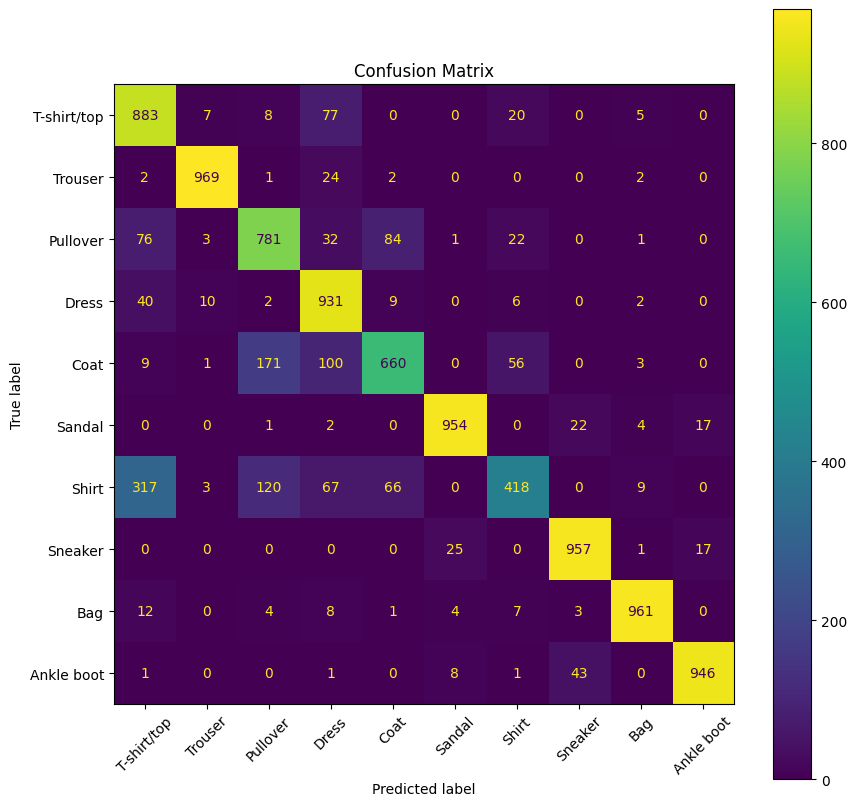

In [15]:
# Confusion matrix and classification report on test set
# Predict class indices for test set
y_pred_probs = model.predict(x_test_flat)
y_pred = np.argmax(y_pred_probs, axis=1)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print('\nClassification report:\n')
print(classification_report(y_test, y_pred, target_names=class_names, digits=4))

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(ax=ax, xticks_rotation=45)
plt.title('Confusion Matrix')
plt.show()

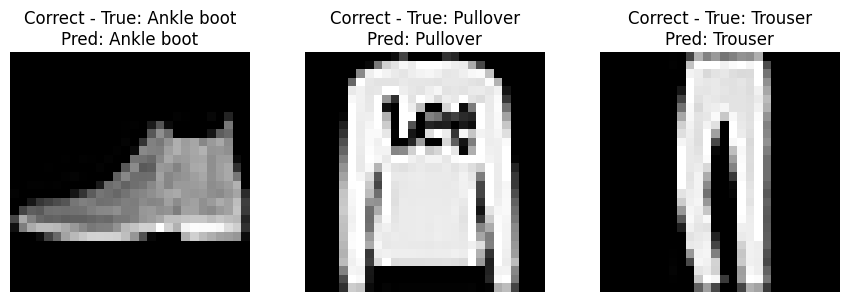

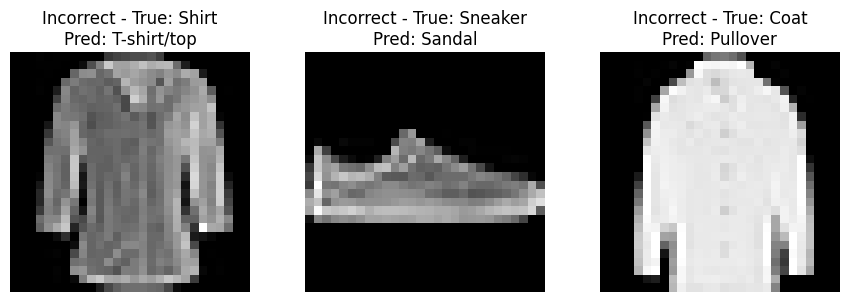

In [16]:

# Show example predictions (correct and incorrect)
# Find indices of correct and incorrect predictions
correct_indices = np.where(y_pred == y_test)[0]
incorrect_indices = np.where(y_pred != y_test)[0]

# Plot some correct predictions
def show_images(indices, title_prefix=''):
    n = len(indices)
    cols = 3
    rows = (n + cols - 1) // cols
    plt.figure(figsize=(cols * 3, rows * 3))
    for i, idx in enumerate(indices[:cols * rows]):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(x_test[idx], cmap='gray')
        plt.title(f"{title_prefix}True: {class_names[y_test[idx]]}\nPred: {class_names[y_pred[idx]]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# show 3 correct and 3 incorrect (or fewer if not available)
n_show = 3
show_images(correct_indices[:n_show], title_prefix='Correct - ')
show_images(incorrect_indices[:n_show], title_prefix='Incorrect - ')

